# Project 3 Web APIs & NLP - Florian Combelles

In week four we've learned about a few different classifiers. In week five we'll learn about webscraping, APIs, and Natural Language Processing (NLP). This project will put those skills to the test.

For project 3, your goal is two-fold:
1. Using [Pushshift's](https://github.com/pushshift/api) API, you'll collect posts from two subreddits of your choosing.
2. You'll then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

###### Requirements

- Gather and prepare your data using the `requests` library.
- **Create and compare two models**. One of these must be a Naive Bayes classifier, however the other can be a classifier of your choosing: logistic regression, KNN, SVM, etc.
- A Jupyter Notebook with your analysis for a peer audience of data scientists.
- An executive summary of your results.
- A short presentation outlining your process and findings for a semi-technical audience.

## Problem Statement and background:

###### Problem Statement

During Covid 19, we have seen an increase in the number of new pet owners in Singapore.
These new inexperienced pet owners are facing a lack of ressources on how to care for their new pets.

This leads to them having to overrely on veterinarians and pet stores to provides information and respond to their queries.

This influx of inexperienced pets owners overly reliant on vets and pet store reduces their work efficiency and distract them from their main responsibilites


##### Background

We are working for a company called Pet Smart.

We are releasing a new mobile app that includes two features:
* A chat box where you can ask your cat or dog related question and get an answer from a team of experts.
* Articles that provides informations and tips on how to care for your pets.


## Part 2: Data Cleaning and EDA

Now that we have asquired the data we need for our models, we need to clean it and see if we can extract some interesting insight from it

##### Importing Libraries

For this second part, we need to import Pandas to handle our dataframes, Matplotlib and Seaborn for visualizations.

We are also importing string, re and NLTK for to process our text. This includes:
* Classification
* Tokenization
* Stemming and Lemmatizing

Finally we also import two CountVectorizer that will transform text into numerical data that will be passed to our models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

###  Data Cleaning / EDA

##### Loading Datasets

We are loading the two datasets that we created during data acquisition

In [2]:
dog = pd.read_csv('data/DogAdvice.csv')
cat = pd.read_csv('data/CatAdvice.csv')

##### Display head

Display the first two entries in both dog and cat dataframes to ensure data has been correctly registered

From this, we can already see that the post_hint column includes null values and that some cleaning will be required

In [3]:
cat.head(2)

,created_utc,domain,is_robot_indexable,selftext,subreddit,title,post_hint
0,1669614166,self.CatAdvice,True,I have a python that I feed live mice to (idk ...,CatAdvice,Cat mouse,NaN
1,1669612518,self.CatAdvice,True,"My cat is 2 and 1/2 years old, but unfortunate...",CatAdvice,How to touch my cats paws and not get murdered?,NaN


In [ ]:
dog.head(2)

##### Displaying columns names

Display columns names to ensure all the data we need is present

In [4]:
print(dog.columns)
print(cat.columns)

Index(['created_utc', 'domain', 'is_robot_indexable', 'selftext', 'subreddit',
       'title', 'post_hint'],
      dtype='object')
Index(['created_utc', 'domain', 'is_robot_indexable', 'selftext', 'subreddit',
       'title', 'post_hint'],
      dtype='object')


##### Display two posts from each subreddit prior to cleaning

We also want to display two posts from each subredddit prior to cleaning so we can compare them with post cleaning

In [65]:
cat.iloc[[100,700],3]

100    Can anyone give me advice for my cat? My mom h...
700    We recently found a stray mom and her 5 kitten...
Name: selftext, dtype: object

In [66]:
dog.iloc[[100,700],3]

101    Hi all I have a 9 month old Dashchund as was w...
707    We've got a 13 month old French bulldog. He is...
Name: selftext, dtype: object

##### Filling NaN values in post_hint with text

post_hint column contains values that refers to the type of content is included inside the submission. Most of the submissions usually includes text only.

We can safely assume that the submissions returning a null post_hint are submissions that do not include any 'content' and are only made up of text. 

As such we will replace all the null values with 'text'

In [ ]:
print(dog['post_hint'].value_counts())

In [7]:
dog['post_hint'].fillna(value= 'text', inplace = True)
cat['post_hint'].fillna(value= 'text', inplace = True)

##### Fill null values in softtext column

We also know that some people on reddit only make use of the title field when submitting their posts. Other people are also sharing content from other website or simply pictures.

This lead to the submission not having any information inside it's selftext field. This would then be transformed to a 'nan' inside our dataframe.

We will be removing these 'nan' words from our dataframe by replacing them with an empty word.

In [8]:
dog['selftext'].fillna(value= '', inplace = True)
cat['selftext'].fillna(value= '', inplace = True)

##### Removing duplicates

Finally, we also know that some people posts content multiple times, either because of some delay in their connection when submitting the post or simply because they want an answer fast. 

However, for our project, these duplicated entries would be detrimental to our models as they would find patterns or trends where there shouldn't be any.

As a result, we will remove these duplicates to ensure we only have original content in our dataset.

In [9]:
cat.drop_duplicates(subset = ['selftext', 'title'], inplace=True)
dog.drop_duplicates(subset = ['selftext', 'title'], inplace=True)

##### Handling removed content

In [10]:
print(dog['is_robot_indexable'].value_counts())
print(cat['is_robot_indexable'].value_counts())

True     974
False     18
Name: is_robot_indexable, dtype: int64
True     986
False     13
Name: is_robot_indexable, dtype: int64


From our previous experiments, we have identified that in the cat subreddit, almost half of the posts ends up being removed/deleted. Whereas in the dog subreddit almost none were removed.

For the sake of posts number balance, we will be ignoring the removed posts from the CatAdvice reddit and only scrape posts that are still active by the time the scraping is done.

This can probably be linked to the rules of both subreddits. The DogAdvice subreddit seems to be more general and open in terms of discussion topics whereas the CatAdvice subreddit seems stricter with the subjects that can be discussed about (ie. no medical advice). Rules being stricter on the CatAdvice subreddit, more posts seems to be removed as they would be in breach of this particular subreddit rules compared to other more lax subreddits.

This results in the CatAdvice subreddit being catered more towards behavioral questions and general questions, whereas DogAdvice subreddit is more towards medical inquiry.

##### Counting numbers of posts with images

In [11]:
print(dog['post_hint'].value_counts())
print(cat['post_hint'].value_counts())

text            648
image           269
hosted:video     55
self             11
link              6
rich:video        3
Name: post_hint, dtype: int64
text    978
self     21
Name: post_hint, dtype: int64


Since the DogAdvice subreddit is more leaning towards medical information, there is a multitude of posts containing images and videos of people asking about specific conditions.

Medical information being restricted on the CatAdvice subreddit we can see that the intgrality of posts are just plain text without any images or videos to support them.

This would be good insights when publishing posts or articles about dogs. 

##### Combine Title and Selftext columns into one

Since we want to classify which subreddit each post belong to, and we know that some posts do not have any selftext, we will combine the title and selftext columns.

We are not dropping the posts with no selftext as they would still have relevant information inside their title field.

In [12]:
dog['content'] = dog[['title', 'selftext']].astype(str).apply(" ".join, axis=1)
cat['content'] = cat[['title', 'selftext']].astype(str).apply(" ".join, axis=1)

In [2]:
# Print first to ensure that the columns where combined successfully

dog['content'].head(5)

NameError: name 'dog' is not defined

In [14]:
# Print first to ensure that the columns where combined successfully

cat['content'].head(5)

0    Cat mouse I have a python that I feed live mic...
1    How to touch my cats paws and not get murdered...
2    Gastric cat My cat could possibly experience g...
3    Seeking cat integration reassurance/advice! He...
4    Newly adopted shelter cat avoiding any contact...
Name: content, dtype: object

##### Removing URL and HTML tags

Since some posts contains iamges, videos or content coming from external sources, there will be some url present inside our text.

We will be removing them from our data as they would only affect performance or our model in a negative way

In [15]:
# Checking for urls inside our content

print(dog['content'].str.contains('http').sum())
print(cat['content'].str.contains('http').sum())

16
23


In [16]:
substring = 'http'
dog[dog.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]
cat[cat.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]

,created_utc,domain,is_robot_indexable,selftext,subreddit,title,post_hint,content
103,1669409773,self.CatAdvice,True,This breeder has been exposed for her cruelty ...,CatAdvice,Rudycats Maine Coon Breeder UK,self,Rudycats Maine Coon Breeder UK This breeder ha...
106,1669407315,self.CatAdvice,True,I got a cat about a week ago and he is about 3...,CatAdvice,Is he attacking me or playing,self,Is he attacking me or playing I got a cat abou...
323,1668881613,self.CatAdvice,True,"Hello, I'm a fourth year BSc (Hons) Veterinary...",CatAdvice,Veterinary Nurse Dissertation Survey,text,"Veterinary Nurse Dissertation Survey Hello, I'..."
459,1668599386,self.CatAdvice,True,Excuse the pictures of his/her bum! We were to...,CatAdvice,Is my kitten a girl or a boy?,self,Is my kitten a girl or a boy? Excuse the pictu...
461,1668593016,self.CatAdvice,True,I keep finding this weird bug in my cats water...,CatAdvice,Weird bug in cats water bowl,self,Weird bug in cats water bowl I keep finding th...
513,1668497882,self.CatAdvice,True,Here is the video of her doing it: https://you...,CatAdvice,My cat does this weird sound while eating. Sho...,self,My cat does this weird sound while eating. Sho...
536,1668458409,self.CatAdvice,True,"Over the last few days, my 7 month old cat hav...",CatAdvice,Help! Does my cat have UTI?,self,Help! Does my cat have UTI? Over the last few ...
538,1668455425,self.CatAdvice,True,Here is a recording of it - anyone know what's...,CatAdvice,Cat pawing at mouth while gagging,self,Cat pawing at mouth while gagging Here is a re...
563,1668387332,self.CatAdvice,True,"We have two cats: Trisk (2 years, former stray...",CatAdvice,8mo kitten attacking 2yo cat,self,8mo kitten attacking 2yo cat We have two cats:...
600,1668348899,self.CatAdvice,True,"Hi everyone,\n\nMy kitty is a white male domes...",CatAdvice,Black stuff on cat's tail...what could it be?,self,Black stuff on cat's tail...what could it be? ...


In [17]:
# Create a function to remove URL from the content

def url_remover(text):
    text_removed = re.sub('http://\S+|https://\S+', '', text)
    return text_removed

dog['content'] = dog['content'].apply(lambda x: url_remover(x))
cat['content'] = cat['content'].apply(lambda x: url_remover(x))

In [18]:
# Checking that our urls have been removed

print(dog['content'].str.contains('http').sum())
print(cat['content'].str.contains('http').sum())

0
0


We also noticed that posts contains the \n html tag inside them. We will also be removing it as it would lead our model to focus on irrelevant information.

In [19]:
# Removing the '\n' tag from HTML code inside the content

# Checking for urls inside our content

print(dog['content'].str.contains('\n').sum())
print(cat['content'].str.contains('\n').sum())

370
609


In [20]:
# Create a function to remove HTML tags from the content

def url_remover(text):
    text_removed = re.sub('\n', '', text)
    return text_removed

dog['content'] = dog['content'].apply(lambda x: url_remover(x))
cat['content'] = cat['content'].apply(lambda x: url_remover(x))

In [21]:
# Removing the '\n' tag from HTML code inside the content

# Checking for urls inside our content

print(dog['content'].str.contains('\n').sum())
print(cat['content'].str.contains('\n').sum())

0
0


### Distribution of posts lenghts

Another information that can be interesting is the sizes of submissions that are posted in both subreddits.

That could give us some insight on the habits of people of each subreddits

In [22]:
# Create a new column that will contain the number of words of each posts

dog['content_word_count'] = dog['content'].map(lambda x: len(x.split()))
cat['content_word_count'] = cat['content'].map(lambda x: len(x.split()))

In [23]:
cat['content_word_count'].head()

0     88
1     86
2    101
3    244
4    546
Name: content_word_count, dtype: int64

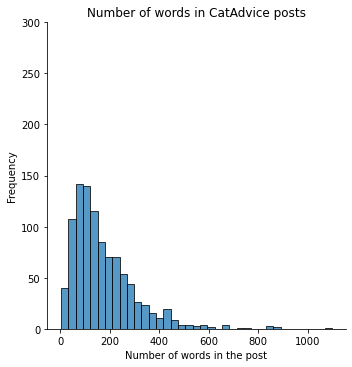

In [24]:
ax = sns.displot(cat['content_word_count'], kde=False, height=5)
ax.set(ylim=(0, 300),
      title = 'Number of words in CatAdvice posts',
       xlabel = "Number of words in the post",
       ylabel = "Frequency")
plt.show()

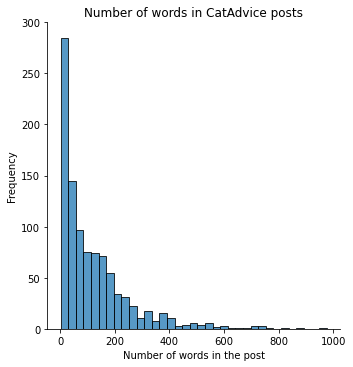

In [25]:
ax = sns.displot(dog['content_word_count'], kde=False)
ax.set(ylim=(0, 300),
      title = 'Number of words in DogAdvice posts',
       xlabel = "Number of words in the post",
       ylabel = "Frequency")
plt.show()

We can see that posts in the CatAdvice subreddit are usually more wordy than the posts on the DogAdvice subreddit.

This can be explained by the fact that people on the DogAdvice tends to posts more images and videos and usaully accompany them with shorter text. 

### Natural Language Processing

Now that we have cleaned our data and found some interesting insight, it's time for us to transform/prepare our data before we can pass it to our Machine Learning models.

Let's preprocess our data
* Remove Punctuations
* Tokenize text
* Remove stop words
* Stem / Lemmatize

##### Remove punctuation

We will start by removing the punctionation.

In order to do so, we will make use of the string.punctuation module from the string library.

It is a pre-initialized string  that includes all the punctuation characters that we intend to remove.

We will define a function that will go through all rows of data and look for the characters in the string.punctuation string. The function will create create a new string without punctuation and assign it to a new column called 'content_clean'.

In order to not have too much unneccesary data inside our dataframe, we will remove the 'content' column as we don't have any need for it anymore

In [ ]:
# Displaying the content of the string.punctuation

string.punctuation

In [26]:
# Create a function to remove the punctuation from our dataset

def punct_remover(text):
    text_clean = "".join([char for char in text if char not in string.punctuation])
    return text_clean

dog['content_clean'] = dog['content'].apply(lambda x: punct_remover(x))
cat['content_clean'] = cat['content'].apply(lambda x: punct_remover(x))

# Drop content column as we won't be using it anymore now that we transformed it

dog.drop(columns= ['content'], inplace= True)
cat.drop(columns= ['content'], inplace = True)

In [27]:
print(dog['content_clean'].head(1))
print(cat['content_clean'].head(1))

0    Dog aggressive to new puppy So my family got a...
Name: content_clean, dtype: object
0    Cat mouse I have a python that I feed live mic...
Name: content_clean, dtype: object


##### Tokenize text

Now that we removed the punctuation from our text, we need to tokenize it.
Tokenization is the act of separating a piece of text (sentence in our case) into smaller units (words) called tokens.

Similarly to the punctuation removal step, we will create a function that will go through each row of text and create tokens for each word present inside.

This new list of tokens will then be stored inside a new column and we will delete the previous column.

In [28]:
# Create a function to tokenize the text in our content_clean column

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

dog['content_token'] = dog['content_clean'].apply(lambda x: tokenize(x.lower()))
cat['content_token'] = cat['content_clean'].apply(lambda x: tokenize(x.lower()))

# Drop content_clean column as we won't be using it anymore now that we transformed it

dog.drop(columns= ['content_clean'], inplace= True)
cat.drop(columns= ['content_clean'], inplace= True)

In [29]:
print(dog['content_token'].head(1))
print(cat['content_token'].head(1))

0    [dog, aggressive, to, new, puppy, so, my, fami...
Name: content_token, dtype: object
0    [cat, mouse, i, have, a, python, that, i, feed...
Name: content_token, dtype: object


##### Remove Stopwords

The next step in our text processing is to remove all the stop words.

Now that our text is composed of tokens, we can transform each word individually.

Let's create a function that will get rid of stopwords as they do not provide any context to the text we are trying to analyze.

We will be using the english stop word corpus from the NLTK library as a base.

In [30]:
# Create a variable that will include all the stopwords from the english dictionary 

stopwords = nltk.corpus.stopwords.words('english')

# Define a function to remove the stopwords from our tokenized text

def stopwords_remover(tokens):
    text = [word for word in tokens if word not in stopwords]
    return text

dog['content_token_clean'] = dog['content_token'].apply(
    lambda x: stopwords_remover(x))
cat['content_token_clean'] = cat['content_token'].apply(
    lambda x: stopwords_remover(x))

# Drop content_token column as we won't be using it anymore now that we transformed it

dog.drop(columns= ['content_token'], inplace= True)
cat.drop(columns= ['content_token'], inplace= True)

In [31]:
print(dog['content_token_clean'].head(3))
print(cat['content_token_clean'].head(3))

0    [dog, aggressive, new, puppy, family, got, new...
1    [get, german, shepherd, puppy, respect, cats, ...
2                  [belly, button, never, seen, one, ]
Name: content_token_clean, dtype: object
0    [cat, mouse, python, feed, live, mice, idk, cr...
1    [touch, cats, paws, get, murdered, cat, 2, 12,...
2    [gastric, cat, cat, could, possibly, experienc...
Name: content_token_clean, dtype: object


##### Stem/Lemmatize

Since we want to be able to identify what users will be typing and recommend them content based on their searches we will need to use lemmatizing.

Lemmatizing will allow us to reduce the word to their root while ensuring that they remains a valid english dictionary word.

We will use WordNet from the NLTK library to achieve this.

In [32]:
# Create a variable to hold the lemmatize class

lemma = nltk.WordNetLemmatizer()

# Define function to lematize our clean tokens

def lemmatizer(clean_tokens):
    lem = [lemma.lemmatize(word) for word in clean_tokens]
    return lem

dog['content_lemmatized'] = dog['content_token_clean'].apply(lambda x: lemmatizer(x))
cat['content_lemmatized'] = cat['content_token_clean'].apply(lambda x: lemmatizer(x))

# Drop content_token_clean column as we won't be using it anymore now that we transformed it

dog.drop(columns= ['content_token_clean'], inplace= True)
cat.drop(columns= ['content_token_clean'], inplace = True)


In [33]:
dog.head()

,created_utc,domain,is_robot_indexable,selftext,subreddit,title,post_hint,content_word_count,content_lemmatized
0,1669615692,self.DogAdvice,True,So my family got a new puppy for some backgrou...,DogAdvice,Dog aggressive to new puppy,text,548,"[dog, aggressive, new, puppy, family, got, new..."
1,1669614240,self.DogAdvice,True,Pretty self-explanatory title. I have a 9 mo o...,DogAdvice,How to get my german shepherd puppy to respect...,text,276,"[get, german, shepherd, puppy, respect, cat, b..."
2,1669613041,i.redd.it,True,,DogAdvice,is this just her belly button? never seen one ...,image,10,"[belly, button, never, seen, one, ]"
3,1669611982,i.redd.it,True,I’ve been to the vet for it before but got no ...,DogAdvice,What could this be,image,26,"[could, vet, got, clear, answer, scab, also, d..."
4,1669611390,/r/DogAdvice/comments/z6n8v5/dog_wont_stop_lic...,True,,DogAdvice,Dog won’t stop licking his paw! Is this normal...,hosted:video,35,"[dog, stop, licking, paw, normal, dog, behavio..."


#### Transform lemmatized column back to a single string of text

After our text has been lemmatized, it will now take the form of a list of words.

However, some text vectorizer also do some transformation steps and need the text we pass to them to be under the form of a string. 

In [34]:
# Use, join to transform lemmatized column back into text

dog['content_joined'] = [' '.join(map(str, l)) for l in dog['content_lemmatized']]
cat['content_joined'] = [' '.join(map(str, l)) for l in cat['content_lemmatized']]

##### Display the same posts after cleaning

If you remember the posts that we printed earleir before our cleaning, they look much different to the ones we have now.

They are now ready to be vectorized in order to be fed to our models.

In [63]:
dog.iloc[[100,700],8]

101    [skincare, advice, dashchund, hi, 9, month, ol...
707    onth, old, still, toileting, crate, weve, ...
Name: content_lemmatized, dtype: object

In [64]:
cat.iloc[[100,700],8]

100    [keep, cat, indoors, good, anyone, give, advic...
700    [get, kitten, stop, nursing, recently, found, ...
Name: content_lemmatized, dtype: object

##### Merge Dog and Cat Dataframe

Now that our text has been transformed we will merge the dog and cat information into the same dataframe

In [35]:
# Using pd.concat to combine both dataframes

cat_dog = pd.concat([dog,cat])

In [36]:
cat_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   created_utc         1991 non-null   int64 
 1   domain              1983 non-null   object
 2   is_robot_indexable  1991 non-null   bool  
 3   selftext            1991 non-null   object
 4   subreddit           1991 non-null   object
 5   title               1991 non-null   object
 6   post_hint           1991 non-null   object
 7   content_word_count  1991 non-null   int64 
 8   content_lemmatized  1991 non-null   object
 9   content_joined      1991 non-null   object
dtypes: bool(1), int64(2), object(7)
memory usage: 157.5+ KB


##### Binarizing Subreddit

Since our machine learning models only accepts numerical values, we need to binarize the subreddit columns as it will be used as our target in our machine learning models

In [37]:
subreddit_bin = {'CatAdvice': 0, 'DogAdvice': 1}

cat_dog.replace({'subreddit': subreddit_bin}, inplace=True)

##### Remove the words Cat, Dog and Advice from content

Also, since we are trying to predict if each post belongs to either the cat or dog subreddit, we will be removing the words cat and dogs from our dataset.

Otherwise, our model will not really be predicting but rather assigning based on this value.

In [39]:
# Create a function to remove the words Dog, Cat and Advice from the content

banned_word = ['dog', 'cat', 'advice', 'cats', 'dogs', 'nan']

def word_remover(text):
    text_noword = ' '.join(word for word in text.split() if word not in banned_word)
    return text_noword

cat_dog['content_joined'] = cat_dog['content_joined'].apply(lambda x: word_remover(x))


##### Remove numbers from our content

We will also be removing the numbers from our content as they will not provide any context when training our machine learning model

In [40]:
# Create a function to remove digits from the content field

def digit_remover(text):
    text_nodigit = ''.join([num for num in text if not num.isdigit()])
    return text_nodigit

cat_dog['content_joined'] = cat_dog['content_joined'].apply(lambda x: digit_remover(x))

Now that we have transformed our raw text into lemmatized clean tokens we can transform these tokens into numbers.
This steps is essential to our machine learning efforts as the machine will only be able to interpret numbers.

##### Force lower case all content in content_joined

In [67]:
#cat_dog['content_joined'].str.lower()

0      aggressive new puppy family got new puppy back...
1      get german shepherd puppy respect boundary pre...
2                            belly button never seen one
3      could vet got clear answer scab also dark spot...
4      stop licking paw normal behavior something wor...
                             ...                        
995    ready panic attack foster ringworm apparently ...
996    perpetually nursing kitten bought  kitten mont...
997    scaredy fostered stray litter  summer planned ...
998    friskies really bad seen ton comment terrible ...
999    encourage teething kitten eat hello  month old...
Name: content_joined, Length: 1991, dtype: object

##### Saving Dataframe to CSV

Now that we finalized transforming all our text, we will save the new dataframe into a csv file that we will call upon during our next steps.

In [68]:
cat_dog.to_csv('data/cat_dog.csv')

### Vectorize

Now that our text is ready, we need to ensure that it can be interpreted by our machine learning models.

In order to do so, we need to use a technique called Word Vectorization (or Word Embedding).This technique will map the words from our dataset into vectors of numbers.

For this, we will be using three different method of word vectorizers:
* Count Vectorizer
* Count Vectorizer with N-Grams
* Term-Frequency - Inverse Document Frequency (TF-IDF)

##### Count Vectorizer

We will start with Count Vectorizer.

In [41]:
# Create instances of CountVectorizer 

count_vect = CountVectorizer(min_df=3, max_df=0.5)
#count_vect_sample = CountVectorizer()

In [42]:
# Store the vectorized versions of our data

X_counts_vect = count_vect.fit_transform(cat_dog['content_joined'])
print(X_counts_vect.shape)

(1991, 3743)


In [43]:
# Apply CountVectorizer do a smaller data sample

#catdog_sample_cv = cat_dog[0:500]

#X_counts_vect_sample = count_vect_sample.fit_transform(catdog_sample_cv['content_joined'])
#print(X_counts_vect_sample.shape)
#print(count_vect_sample.get_feature_names())

In [44]:
# Save Sparse Matrix into a DataFrame and convert the columns name to the features names

count_vect_df = pd.DataFrame(X_counts_vect.toarray())
count_vect_df.columns = count_vect.get_feature_names()

count_vect_df.head()

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandoned,ability,able,abnormal,abroad,abruptly,absolute,absolutely,abuse,abused,...,youngest,youre,youtube,youve,yowl,yowling,yr,yrs,zero,zoomies
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Display the most occuring terms

<AxesSubplot:>

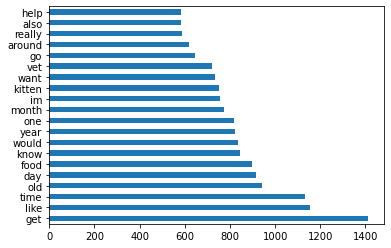

In [45]:
count_vect_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')

Displaying the most occurring terms will help us identify what words are most oftenly used for each Vectorizing method.

In the case of the Count Vectorizer, we can see that a lot of posts are around food, kitten and people are usually seeking help or vet advice

In [46]:
# Save Sparse Matrix to CSV

count_vect_df.to_csv('data/count_vect_df.csv')

##### Count Vectorizer with N-Grams

In [47]:
# Create instances of CountVectorizer with N-Grams parameters

count_vect_ng = CountVectorizer(ngram_range= (2,2), min_df=3, max_df=0.5)
count_vect_ng_sample = CountVectorizer(ngram_range= (1,3))

In [48]:
# Store the N-Gram vectorized versions of our data

X_counts_ng = count_vect_ng.fit_transform(cat_dog['content_joined'])
print(X_counts_ng.shape)

(1991, 4900)


In [49]:
# Apply N-Gram CountVectorizer do a smaller data sample

#catdog_sample_ng = cat_dog[0:500]

#X_counts_ng_sample = count_vect_ng_sample.fit_transform(catdog_sample_ng['content_joined'])
#print(X_counts_ng_sample.shape)
#print(count_vect_ng_sample.get_feature_names())

In [50]:
# Save Sparse Matrix into a DataFrame and convert the columns name to the features names

count_ng_df = pd.DataFrame(X_counts_ng.toarray())
count_ng_df.columns = count_vect_ng.get_feature_names()

count_ng_df.head()

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able find,able get,able handle,able help,able keep,able move,able run,able sleep,able socialize,able stop,...,yo spayed,yo weve,youd think,young adult,young got,young kitten,young one,younger one,yr old,yrs old
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

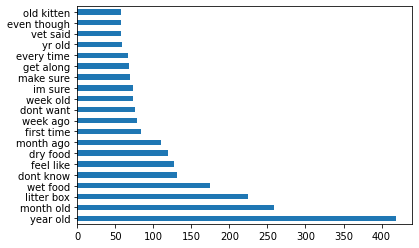

In [51]:
count_ng_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')

Using Count Vectorizer with N-grams allows us to see words as either unigram, bigram or trigram. 

In this case, we chose to use bigrams. This allows us to see which combination of two words is the most common.

People seems interested in litter box, wet and dry food, or what they information they got from vets

In [52]:
# Saving Sparse Matrix to CSV

count_ng_df.to_csv('data/count_ng_df.csv')

##### TF-IDF (Term Frequency - Inverse Document Frequency)

In [53]:
# Create instances of CountVectorizer with TFIDF parameters

count_vect_tfidf = TfidfVectorizer()
count_vect_tfidf_sample = TfidfVectorizer()

In [54]:
# Store the TFIDF vectorized versions of our data

X_counts_tfidf = count_vect_tfidf.fit_transform(cat_dog['content_joined'])
print(X_counts_tfidf.shape)

(1991, 10880)


In [55]:
# Apply N-Gram CountVectorizer do a smaller data sample

#catdog_sample_tfidf = cat_dog[0:500]

#X_counts_tfidf_sample = count_vect_tfidf_sample.fit_transform(catdog_sample_ng['content_joined'])
#print(X_counts_tfidf_sample.shape)
#print(count_vect_tfidf_sample.get_feature_names())

In [56]:
# Save Sparse Matrix into a DataFrame and convert the columns name to the features names

count_tfidf_df = pd.DataFrame(X_counts_tfidf.toarray())
count_tfidf_df.columns = count_vect_tfidf.get_feature_names()

count_tfidf_df.head()

C:\Users\flori\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaaaa,ab,abandon,abandoned,abandonedfor,abandoning,abandonment,abdomen,abdominal,abig,...,zone,zoom,zoomies,zooming,zora,zucchini,zuchon,zuzu,zylkene,zyrtec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Saving Sparse Matrix to CSV

count_tfidf_df.to_csv('data/count_tfidf_df.csv')

<AxesSubplot:>

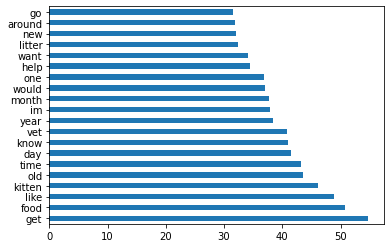

In [58]:
count_tfidf_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')

TF-IDF is a version of Count Vectorizer that will apply a penalty to each word based on it's frequency in the corpus.

As such the results for most common words are somehow different from the Count Vectorizer.

### Conclusion

During our data cleaning:
* We identified that we had null values and have dealt with them.
* We removed duplicated
* We removed html urls and tags
* Combined our two dataframes into one
* Used Word Vectorizer techniques to prepare our text for the modelling part.

We also identified interesting insight:
* DogAdvice contains a lot of pictures and videos whereas CatAdvice contains none
* People in DogAdvice subreddit posts are usually much shorter than in the CatAdvice

We can now move on to the modelling part of our project.